In [1]:
from sklearn.datasets.samples_generator import make_regression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

plt.rcParams['figure.figsize'] = (10,7)
%matplotlib inline

In [3]:
m = 2000       
n = 200                                       
N = 10

X, y = make_regression(n_samples = m,
                       n_features= n,
                       n_targets = N,
                       random_state=0)

tr_size = int(m*0.8)
Xtr = X[:tr_size,:]
Xtst = X[tr_size:,:]
ytr = y[:tr_size,:]
ytst = y[tr_size:,:]

In [4]:
Nc = 2
Nd = 8
yc_idx = [8,9]
yd_idx = [0,1,2,3,4,5,6,7]
yc_tr = ytr[:,yc_idx]
yd_tr = ytr[:,yd_idx]
yc_tst = ytst[:,yc_idx]
yd_tst = ytst[:, yd_idx]

In [5]:
Xtr_t = torch.FloatTensor(Xtr)
ytr_t = torch.FloatTensor(ytr)
Xtst_t = torch.FloatTensor(Xtst)
ytst_t = torch.FloatTensor(ytst)

yc_tr_t = torch.FloatTensor(yc_tr)
yd_tr_t = torch.FloatTensor(yd_tr)
yc_tst_t = torch.FloatTensor(yc_tst)
yd_tst_t = torch.FloatTensor(yd_tst)

## Linear Regression for y_c and y_d
First check the $e_c$ and $e_d$ on raw (uncleaned data) $X$

In [6]:
lr = LinearRegression()
lr.fit(Xtr, yc_tr)         
y_hat = lr.predict(Xtst) 
print("e_c:", np.linalg.norm(yc_tst - y_hat)) 

lr = LinearRegression()
lr.fit(Xtr, yd_tr)         
y_hat = lr.predict(Xtst) 
print("e_d:", np.linalg.norm(yd_tst - y_hat)) 

e_c: 1.40270942601e-11
e_d: 2.68488149194e-11


# Training a network same as discriminator for y_c and y_d prediction
Now try the same, i.e. predict $y_c$ and $y_d$ from a neural net of the same type as the one we will use as discriminator in the GAN. 

Error for CONFIDENTIAL Labels with Raw Data 8.148395136231557e-05
Error for DESIRED Labels with Raw Data 0.027695100754499435


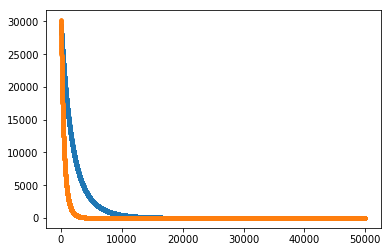

In [7]:
def Discriminator(D_in, D_out):
    model = torch.nn.Sequential(
            torch.nn.Linear(D_in, D_out, bias = True))
    return model

def Generator(D_in, D_out):
    model = torch.nn.Sequential(
            torch.nn.Linear(D_in, D_out, bias = True))
    return model

learning_rate = 1e-4
discriminator_loss = torch.nn.MSELoss(size_average=True)
Netc = Discriminator(n, Nc)
Netd = Discriminator(n, Nd)
Netc_opt = torch.optim.SGD(Netc.parameters(), lr = learning_rate, momentum=0.9)
Netd_opt = torch.optim.SGD(Netd.parameters(), lr = learning_rate, momentum=0.9)

d_losses = []
c_losses = []
for i in range(50000):
    Netc.zero_grad()
    Netd.zero_grad()
    yc_hat = Netc(Variable(Xtr_t))
    yd_hat = Netd(Variable(Xtr_t))
    Netc_loss = discriminator_loss(yc_hat, Variable(yc_tr_t))
    Netd_loss = discriminator_loss(yd_hat, Variable(yd_tr_t))
    
    c_losses.append(Netc_loss.data[0])
    d_losses.append(Netd_loss.data[0])
    
    Netc_loss.backward()
    Netd_loss.backward()
    
    Netc_opt.step()
    Netd_opt.step()
    
plt.plot(d_losses,'.')
plt.plot(c_losses,'.')

yc_hat = Netc(Variable(Xtst_t))
yd_hat = Netd(Variable(Xtst_t))
Netc_loss_test = discriminator_loss(yc_hat, Variable(yc_tst_t))
Netd_loss_test = discriminator_loss(yd_hat, Variable(yd_tst_t))
print("Error for CONFIDENTIAL Labels with Raw Data", Netc_loss_test.data[0])
print("Error for DESIRED Labels with Raw Data", Netd_loss_test.data[0])

## GANs for data cleaning

In [8]:
def Discriminator(D_in, D_out):
    model = torch.nn.Sequential(
            torch.nn.Linear(D_in, D_out, bias = True))
    return model

def Generator(D_in, D_out):
    model = torch.nn.Sequential(
            torch.nn.Linear(D_in, D_out, bias = True))
    return model

learning_rate = 1e-6
discriminator_loss = torch.nn.MSELoss(size_average=True)
Dc = Discriminator(n, Nc)
Dd = Discriminator(n, Nd)
Dc_opt = torch.optim.SGD(Dc.parameters(), lr = learning_rate, momentum=0.9)
Dd_opt = torch.optim.SGD(Dd.parameters(), lr = learning_rate, momentum=0.9)

G = Generator(n, n)
G_opt = torch.optim.SGD(G.parameters(), lr = learning_rate, momentum=0.9)

27666.857421875 24363.39453125


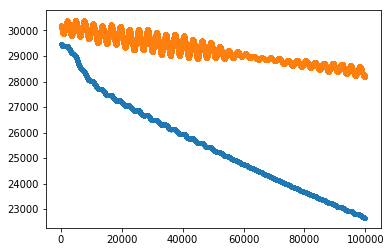

In [9]:
d_losses = []
c_losses = []
for i in range(100000):
    
    # Get Raw discriminator loss
    Dc.zero_grad()
    Dd.zero_grad()
    yc_hat = Dc(Variable(Xtr_t))
    yd_hat = Dd(Variable(Xtr_t))
    Dc_loss_raw = discriminator_loss(yc_hat, Variable(yc_tr_t))
    Dd_loss_raw = discriminator_loss(yd_hat, Variable(yd_tr_t))
    
    c_losses.append(Dc_loss_raw.data[0])
    d_losses.append(Dd_loss_raw.data[0])
    
    ## get Cleaned discriminators loss
    X_hat = G(Variable(Xtr_t))
    yc_hat = Dc(X_hat)
    yd_hat = Dd(X_hat)
    Dc_loss_clean = discriminator_loss(yc_hat, Variable(yc_tr_t))
    Dd_loss_clean = discriminator_loss(yd_hat, Variable(yd_tr_t))
    
    # Train discriminator on total loss
    Dc_loss = Dc_loss_clean + Dc_loss_raw
    Dd_loss = Dd_loss_clean + Dd_loss_raw
    D_loss = Dc_loss + Dd_loss
    
    D_loss.backward(retain_graph=True)
    Dc_opt.step()
    Dd_opt.step()
    
    ## Train Generator
    G.zero_grad()
    G_loss = Dd_loss_clean - Dc_loss_clean
    G_loss.backward()
    G_opt.step()
    
plt.plot(d_losses,'.')
plt.plot(c_losses,'.')

yc_hat = Dc(Variable(Xtst_t))
yd_hat = Dd(Variable(Xtst_t))
Dc_loss_test = discriminator_loss(yc_hat, Variable(yc_tst_t))
Dd_loss_test = discriminator_loss(yd_hat, Variable(yd_tst_t))
print(Dc_loss_test.data[0], Dd_loss_test.data[0])

To check if the discriminators are trained properly on raw data, check error while predicting from raw data

In [10]:
yc_hat = Dc(Variable(Xtst_t))
yd_hat = Dd(Variable(Xtst_t))
Dc_loss_test = discriminator_loss(yc_hat, Variable(yc_tst_t))
Dd_loss_test = discriminator_loss(yd_hat, Variable(yd_tst_t))
print(Dc_loss_test.data[0], Dd_loss_test.data[0])


27666.857421875 24363.39453125


Now check the error of $y_c$ and $y_d$ for cleaned data

In [11]:
X_hat = G(Variable(Xtst_t))
yc_hat = Dc(X_hat)
yd_hat = Dd(X_hat)
Dc_loss_test = discriminator_loss(yc_hat, Variable(yc_tst_t))
Dd_loss_test = discriminator_loss(yd_hat, Variable(yd_tst_t))
print(Dc_loss_test.data[0], Dd_loss_test.data[0])
print("Error for CONFIDENTIAL Labels with Cleaned Data", Dc_loss_test.data[0])
print("Error for DESIRED Labels with Cleaned Data", Dd_loss_test.data[0])

23170.404296875 9388.720703125
Error for CONFIDENTIAL Labels with Cleaned Data 23170.404296875
Error for DESIRED Labels with Cleaned Data 9388.720703125


In [12]:
X_hat = G(Variable(Xtr_t))
lr = LinearRegression()
lr.fit(X_hat.data.numpy(), yc_tr)         
y_hat = lr.predict(Xtst) 
print("e_c:", np.linalg.norm(yc_tst - y_hat)) 

lr = LinearRegression()
lr.fit(X_hat.data.numpy(), yd_tr)         
y_hat = lr.predict(Xtst) 
print("e_d:", np.linalg.norm(yd_tst - y_hat)) 

e_c: 37015.4529217
e_d: 39089.7639171
